In [1]:
import sys
import pandas
import sklearn
import imblearn
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import pyplot

#sklearn pre-processing 
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

# sklearn classifier model
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier

# sklearn bagging and boosting 
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# model ensemble learning 
from sklearn.ensemble import VotingClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import validation_curve


# xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance

# pandas.set_option('display.max_columns', None)
# pandas.set_option('display.max_rows', None)

### Read CSV

In [2]:
df = pandas.read_csv("ufcdata/data.csv").drop(columns = ["Referee", "R_fighter", "B_fighter", "location", "date"]).dropna().reset_index()
df = df.drop(columns = ["index"])
df.title_bout = df.title_bout.astype(int)

# conver the winner into int
df["Winner"][df["Winner"] == "Red"] = 1
df["Winner"][df["Winner"] == "Blue"] = 2
df["Winner"][df["Winner"] == "Draw"] = 3


df = df[df["Winner"] != "Draw"].reset_index(drop=True)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [3]:
# Count the Y distribtion 
df["Winner"].value_counts()

1    2023
2    1141
3      51
Name: Winner, dtype: int64

### EDA Work

In [4]:
# Get both player status 
R_status = []
B_status = []

# global status (referee, weight classes...etc)
global_status = []
for i in list(df.keys()):
    if("R_" in i[:3]):
        R_status.append(i)
    elif("B_" in i):
        B_status.append(i)
    else:
        global_status.append(i)
B_status.remove("B_Stance")
R_status.remove("R_Stance")

len(R_status), len(B_status)

(67, 67)

In [5]:
len(global_status)
global_status

['Winner', 'title_bout', 'weight_class', 'no_of_rounds']

In [6]:
# R_ and B_ Stance convert into one-hot
df1 = pandas.DataFrame()
for side in ["R_", "B_"]:
    keys = list(sorted(df[side+"Stance"].unique()))
    lis = list()
    for i in df[side+"Stance"].tolist():
        zero = np.zeros((1,len(keys)))
        zero[0][keys.index(i)] = 1
        lis.append(zero[0])
    _keys = []
    
    for i in keys: # rename columns 
        _keys.append(side+i)
        
    df_temp = pandas.DataFrame(lis, columns = _keys)
    
    for i in df_temp.keys(): # append together
        df1[i] = df_temp[i]
df1.tail()

,R_Open Stance,R_Orthodox,R_Southpaw,R_Switch,B_Open Stance,B_Orthodox,B_Southpaw,B_Switch
3210,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3211,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3212,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3213,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3214,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
# Weight class feature to one-hot

keys = list(sorted(df["weight_class"].unique()))
lis = list()

for i in df["weight_class"].tolist():
    zero = np.zeros((1,len(keys)))
    zero[0][keys.index(i)] = 1
    lis.append(zero[0])

df2 = pandas.DataFrame(lis, columns = keys).astype('float')

df2.tail()

,Bantamweight,Catch Weight,Featherweight,Flyweight,Heavyweight,Light Heavyweight,Lightweight,Middleweight,Welterweight,Women's Bantamweight,Women's Featherweight,Women's Flyweight,Women's Strawweight
3210,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3212,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3214,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Combine three dataframe
temp_df = df

drop_list = ["R_Stance", "B_Stance", "weight_class"]
df = (pandas.concat([df, df1,df2], axis=1)).drop(columns = drop_list)
df = df.astype('float')
df


,Winner,title_bout,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,...,Flyweight,Heavyweight,Light Heavyweight,Lightweight,Middleweight,Welterweight,Women's Bantamweight,Women's Featherweight,Women's Flyweight,Women's Strawweight
0,1.0,1.0,5.0,0.0,4.0,0.0,9.200000,6.000000,0.200000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,5.0,0.0,3.0,0.0,14.600000,9.100000,11.800000,7.300000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,3.0,0.0,3.0,0.0,15.354839,11.322581,6.741935,4.387097,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,3.0,0.0,4.0,0.0,17.000000,14.000000,13.750000,11.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,0.0,3.0,0.0,1.0,0.0,17.000000,14.500000,2.500000,2.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,3.0,0.0,3.0,0.0,15.000000,7.416667,6.083333,3.416667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2.0,0.0,3.0,1.0,0.0,0.0,16.250000,11.000000,17.500000,11.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,2.0,0.0,3.0,0.0,1.0,0.0,7.250000,4.750000,1.750000,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,3.0,0.0,1.0,0.0,25.400000,17.900000,22.500000,16.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,2.0,0.0,3.0,1.0,0.0,0.0,5.428571,4.142857,12.285714,9.142857,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# The differeance between two fighter
new_key = []
for i in B_status:
    new_key.append(i.replace("B_", "Difference_"))

df3 = pandas.DataFrame(df[B_status].to_numpy() - df[R_status].to_numpy(), columns = new_key)
df3.tail()


,Difference_current_lose_streak,Difference_current_win_streak,Difference_draw,Difference_avg_BODY_att,Difference_avg_BODY_landed,Difference_avg_CLINCH_att,Difference_avg_CLINCH_landed,Difference_avg_DISTANCE_att,Difference_avg_DISTANCE_landed,Difference_avg_GROUND_att,...,Difference_win_by_Decision_Split,Difference_win_by_Decision_Unanimous,Difference_win_by_KO/TKO,Difference_win_by_Submission,Difference_win_by_TKO_Doctor_Stoppage,Difference_wins,Difference_Height_cms,Difference_Reach_cms,Difference_Weight_lbs,Difference_age
3210,0.0,1.0,0.0,5.523810,5.238095,5.714286,5.714286,-1.619048,2.285714,-10.619048,...,0.0,-1.0,0.0,0.0,-1.0,-2.0,-7.62,0.00,-20.0,4.0
3211,0.0,0.0,0.0,8.333333,8.000000,-10.666667,-6.333333,-22.000000,-8.666667,44.666667,...,0.0,0.0,0.0,0.0,-1.0,-1.0,-12.70,-5.08,42.0,-1.0
3212,-1.0,1.0,0.0,4.400000,4.900000,8.700000,10.200000,-11.600000,-2.900000,-27.100000,...,0.0,0.0,-1.0,0.0,-1.0,-2.0,-10.16,0.00,0.0,-2.0
3213,-2.0,1.0,0.0,6.500000,4.000000,33.500000,19.500000,45.500000,18.000000,4.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,2.54,5.08,20.0,6.0
3214,0.0,1.0,0.0,0.166667,0.166667,8.666667,4.000000,2.666667,1.666667,0.333333,...,0.0,0.0,2.0,-1.0,0.0,1.0,-2.54,-2.54,-20.0,-14.0


In [10]:
# Combine df3 as well
df = pandas.concat([df, df3], axis=1)
df.tail()

,Winner,title_bout,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,...,Difference_win_by_Decision_Split,Difference_win_by_Decision_Unanimous,Difference_win_by_KO/TKO,Difference_win_by_Submission,Difference_win_by_TKO_Doctor_Stoppage,Difference_wins,Difference_Height_cms,Difference_Reach_cms,Difference_Weight_lbs,Difference_age
3210,1.0,1.0,5.0,0.0,3.0,0.0,7.666667,6.666667,10.000000,7.0,...,0.0,-1.0,0.0,0.0,-1.0,-2.0,-7.62,0.00,-20.0,4.0
3211,1.0,0.0,3.0,0.0,1.0,0.0,12.000000,10.000000,6.000000,3.0,...,0.0,0.0,0.0,0.0,-1.0,-1.0,-12.70,-5.08,42.0,-1.0
3212,1.0,1.0,5.0,0.0,1.0,0.0,7.000000,6.500000,14.500000,12.0,...,0.0,0.0,-1.0,0.0,-1.0,-2.0,-10.16,0.00,0.0,-2.0
3213,1.0,0.0,2.0,0.0,1.0,0.0,9.000000,6.000000,36.000000,21.0,...,0.0,1.0,0.0,0.0,0.0,1.0,2.54,5.08,20.0,6.0
3214,1.0,0.0,2.0,0.0,3.0,0.0,0.666667,0.666667,8.666667,4.0,...,0.0,0.0,2.0,-1.0,0.0,1.0,-2.54,-2.54,-20.0,-14.0


In [11]:
Y = df["Winner"].tolist()

In [12]:
# scale data 
scale_df = df.drop(columns = ["Winner"])
keys = list(scale_df.keys())

scaler = MinMaxScaler()
MinMaxScaler(copy=True, feature_range=(0, 1))
scaler.fit(scale_df)
scale_df = scaler.transform(scale_df)
scale_df = pandas.DataFrame(scale_df, columns = keys)
df = scale_df


In [13]:
df["Winner"] = Y

In [14]:
df["Winner"].value_counts()

1.0    2023
2.0    1141
3.0      51
Name: Winner, dtype: int64

### Feature Importance

In [15]:
                             
X = df.drop(columns = ["Winner"])
Y =  df["Winner"]

In [16]:
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

forest.fit(X,Y)
importances = forest.feature_importances_

In [17]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(0,10):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], df.keys()[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature 223 Difference_age (0.010819)
2. feature 135 R_age (0.008620)
3. feature 96 R_losses (0.007206)
4. feature 106 R_avg_opp_HEAD_landed (0.006490)
5. feature 185 Difference_losses (0.006327)
6. feature 125 R_win_by_Decision_Split (0.006110)
7. feature 113 R_avg_opp_SIG_STR_landed (0.006087)
8. feature 134 B_age (0.006027)
9. feature 102 R_avg_opp_DISTANCE_landed (0.005915)
10. feature 207 Difference_avg_opp_TD_pct (0.005812)


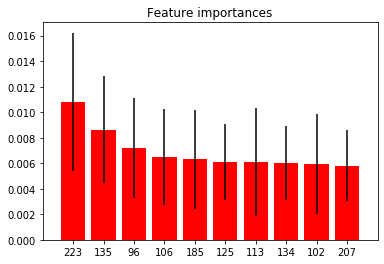

In [18]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(0,10), importances[indices[:10]],
       color="r", yerr=std[indices][:10], align="center")
plt.xticks(range(0,10), indices)
plt.xlim([-1, 10])
plt.show()

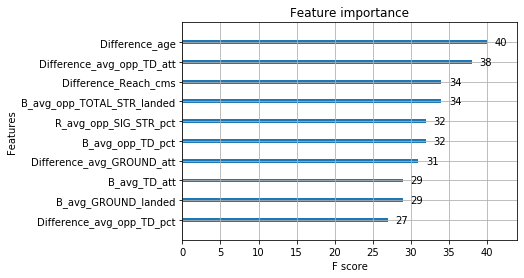

In [19]:
model = XGBClassifier()
model.fit(X, Y)

# plot feature importance
plot_importance(model, max_num_features= 10)
pyplot.show()

In [20]:
def feat_importance(m, df):
    return pandas.DataFrame({'Feature':df.columns, 'Importance':m.feature_importances_}).sort_values('Importance', ascending=False)


fi = feat_importance(model, X); fi[:10]

,Feature,Importance
113,R_avg_opp_SIG_STR_landed,0.027519
223,Difference_age,0.018228
185,Difference_losses,0.012974
20,B_avg_SIG_STR_att,0.011523
21,B_avg_SIG_STR_landed,0.011158
13,B_avg_HEAD_att,0.011058
193,Difference_avg_opp_GROUND_landed,0.009489
9,B_avg_DISTANCE_att,0.008872
77,R_avg_GROUND_att,0.008863
194,Difference_avg_opp_HEAD_att,0.008743


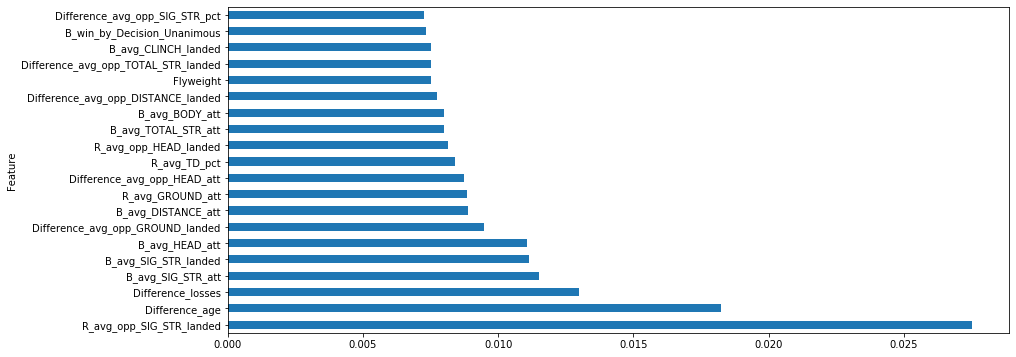

In [21]:
plot1 = fi[:20].plot('Feature', 'Importance', figsize=(14,6), legend=False, kind = 'barh')
plot1;

### Differeance feature values

In [22]:
X = df3

In [23]:
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

forest.fit(X,Y)
importances = forest.feature_importances_

In [24]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(0,10):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], df3.keys()[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature 66 Difference_age (0.028522)
2. feature 28 Difference_losses (0.018839)
3. feature 50 Difference_avg_opp_TD_pct (0.017255)
4. feature 64 Difference_Reach_cms (0.017246)
5. feature 57 Difference_win_by_Decision_Split (0.017015)
6. feature 46 Difference_avg_opp_SIG_STR_pct (0.016766)
7. feature 39 Difference_avg_opp_KD (0.016579)
8. feature 23 Difference_avg_TD_landed (0.016393)
9. feature 36 Difference_avg_opp_GROUND_landed (0.016211)
10. feature 53 Difference_total_rounds_fought (0.016015)


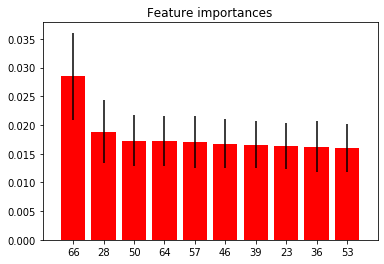

In [25]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(0,10), importances[indices[:10]],
       color="r", yerr=std[indices][:10], align="center")
plt.xticks(range(0,10), indices)
plt.xlim([-1, 10])
plt.show()

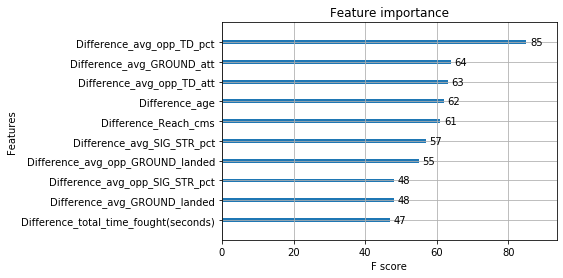

In [26]:
model = XGBClassifier()
model.fit(X, Y)

# plot feature importance
plot_importance(model, max_num_features= 10)
pyplot.show()

In [27]:
def feat_importance(m, df):
    return pandas.DataFrame({'Feature':df.columns, 'Importance':m.feature_importances_}).sort_values('Importance', ascending=False)


fi = feat_importance(model, X); fi[:10]

,Feature,Importance
66,Difference_age,0.047595
28,Difference_losses,0.034561
57,Difference_win_by_Decision_Split,0.026238
36,Difference_avg_opp_GROUND_landed,0.024770
1,Difference_current_win_streak,0.021978
45,Difference_avg_opp_SIG_STR_landed,0.021793
3,Difference_avg_BODY_att,0.021374
46,Difference_avg_opp_SIG_STR_pct,0.019976
39,Difference_avg_opp_KD,0.019262
38,Difference_avg_opp_HEAD_landed,0.019040


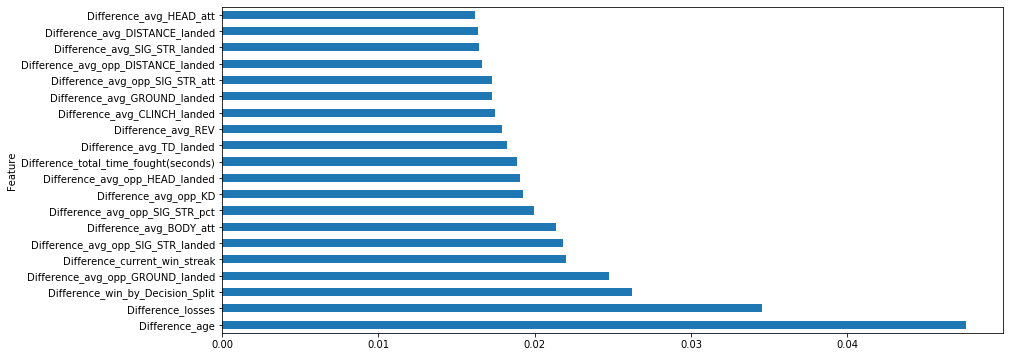

In [28]:
plot1 = fi[:20].plot('Feature', 'Importance', figsize=(14,6), legend=False, kind = 'barh')
plot1;

### Sampling the dataset

In [29]:
# over_sampling for "draw / 3".
X = df.drop(columns = ["Winner"])

rus = imblearn.over_sampling.ADASYN(ratio={3:300 }, random_state=1)

X_rus, Y_rus = rus.fit_sample(X, Y)

print(Counter(Y_rus))


Counter({1.0: 2023, 2.0: 1141, 3.0: 300})


In [30]:
sampled_df = pandas.DataFrame(X_rus, dtype = float, columns = df.drop(columns = ["Winner"]).keys())
sampled_df["Winner"] = Y_rus
df = sampled_df

### Dataset 

In [31]:
# dataset = shuffle(sampled_df)
dataset = shuffle(df)


Train_dataset = dataset[100:-200] 
Valid_dataset = dataset[:100] # 100 dataset for valid
Test_dataset = dataset[-200:] # 200 dataset for test

Train_X = Train_dataset.drop(columns = ["Winner"]).to_numpy(dtype = float)
Train_Y = Train_dataset["Winner"].to_numpy(dtype = int)


Valid_X = Valid_dataset.drop(columns = ["Winner"]).to_numpy(dtype = float)
Valid_Y = Valid_dataset["Winner"].to_numpy(dtype = int)


Test_X = Test_dataset.drop(columns = ["Winner"]).to_numpy(dtype = float)
Test_Y = Test_dataset["Winner"].to_numpy(dtype = int)
pandas.DataFrame(Test_Y, columns = ["Y"])["Y"].value_counts(), 


(1    122
 2     65
 3     13
 Name: Y, dtype: int64,)

In [32]:
pandas.DataFrame(Train_Y, columns = ["Y"])["Y"].value_counts()

1    1853
2    1035
3     276
Name: Y, dtype: int64

In [33]:
pandas.DataFrame(Valid_Y, columns = ["Y"])["Y"].value_counts()

1    48
2    41
3    11
Name: Y, dtype: int64

# ML Models

### Ensembling learning method

In [34]:
def CV(model, X, Y, param, param_val):
    # Calculate accuracy on training and test set using range of parameter values
    train_scores, test_scores = validation_curve(model, 
                                                 X, 
                                                 Y, 
                                                 param_name= param, 
                                                 param_range=param_val,
                                                 cv=2, 
                                                 scoring="f1_weighted", 
                                                 n_jobs=-1)
    test_scores = np.mean(test_scores, axis=1)
    train_scores = np.mean(train_scores, axis=1)

    print(np.max(test_scores))
    return train_scores, test_scores, list(param_val)[np.argmax(test_scores)], np.max(test_scores)

In [35]:
# Bagging for the model and return the best selection via given datasets
rng = np.random.RandomState(1)

def Bagging(model, Train_X, Train_Y, Vail_X, Vail_Y):  
    highest = 0
    coeff = 0
    rng = np.random.RandomState(1)
    Bagging_Model = BaggingClassifier(base_estimator= model,  bootstrap=True, warm_start=False) #
    train_scores, test_scores, coeff, highest = CV(Bagging_Model, Train_X, Train_Y, "n_estimators", range(1, 30, 1))

    return coeff, highest, train_scores, test_scores



In [36]:
# GBDT(Gradient Boosting Decision Tree) for the model and return the best selection via given datasets


def GBDT(model, Train_X, Train_Y, Vail_X, Vail_Y):
    coeff = 0
    highest = 0
    _range = np.arange(1e-4, 5e-2, 5e-3)
#     _range = np.array([2, 1.5, 1e0, 0.5, 1e-1])
    GBDT = GradientBoostingClassifier(init = model, learning_rate = 0.1)
    train_scores, test_scores, coeff, highest = CV(GBDT, Train_X, Train_Y, "learning_rate", _range)


    return coeff, highest, train_scores, test_scores,
    

In [37]:
def plot(train_scores, test_scores):
    fig, ax = plt.subplots()
    ax.plot(train_scores, color = "blue", label = "Train")
    ax.plot(test_scores, color = "red", label = "Test")


    ax.set(xlabel='Numbers of Parameters', ylabel='F1 Weighted',
           title='F1 Weight Accuracy')

    ax.grid()
    # ax.set_xlim([0.01,0.5])

    plt.legend(loc='best')

    plt.show()

### Naive Bayes Classifier

In [38]:
NB = MultinomialNB(class_prior = [0.9,0.95,0.75], alpha = 1)
NB.fit(Train_X, Train_Y)
NB.score(Train_X, Train_Y)

0.497787610619469

In [39]:
print(sklearn.metrics.classification_report(Train_Y, NB.predict(Train_X)) )

              precision    recall  f1-score   support

           1       0.70      0.50      0.58      1853
           2       0.41      0.53      0.46      1035
           3       0.21      0.39      0.27       276

    accuracy                           0.50      3164
   macro avg       0.44      0.47      0.44      3164
weighted avg       0.56      0.50      0.52      3164



In [40]:
NB.score(Test_X, Test_Y)

0.46

In [41]:
print(sklearn.metrics.classification_report(Test_Y, NB.predict(Test_X)) )

              precision    recall  f1-score   support

           1       0.69      0.46      0.55       122
           2       0.40      0.49      0.44        65
           3       0.11      0.31      0.16        13

    accuracy                           0.46       200
   macro avg       0.40      0.42      0.38       200
weighted avg       0.56      0.46      0.49       200



0.49966952356386474


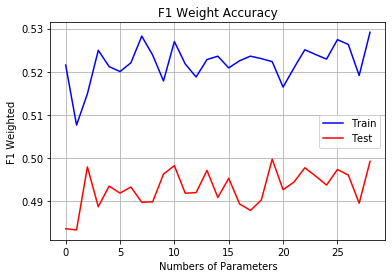

In [42]:
# Bagging Naive Bayes model
coeff, highest, train_scores, test_scores = Bagging(NB, Train_X, Train_Y, Valid_X, Valid_Y)
plot(train_scores, test_scores)

In [43]:
Bagging_NB = BaggingClassifier(base_estimator=NB, n_estimators=coeff, random_state=rng)
Bagging_NB.fit(Train_X, Train_Y)
Bagging_NB.score(Train_X,Train_Y)

0.5012642225031606

In [44]:
print(sklearn.metrics.classification_report(Train_Y, Bagging_NB.predict(Train_X)) )

              precision    recall  f1-score   support

           1       0.70      0.50      0.58      1853
           2       0.41      0.53      0.46      1035
           3       0.21      0.39      0.28       276

    accuracy                           0.50      3164
   macro avg       0.44      0.47      0.44      3164
weighted avg       0.56      0.50      0.52      3164



In [45]:
Bagging_NB.score(Test_X, Test_Y)

0.44

In [46]:
print(sklearn.metrics.classification_report(Test_Y, Bagging_NB.predict(Test_X)) )

              precision    recall  f1-score   support

           1       0.67      0.46      0.55       122
           2       0.36      0.43      0.39        65
           3       0.10      0.31      0.15        13

    accuracy                           0.44       200
   macro avg       0.38      0.40      0.36       200
weighted avg       0.53      0.44      0.47       200



0.6016908189067574


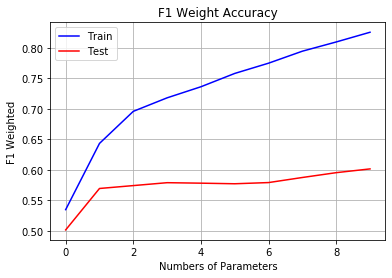

In [47]:
# Gradient Boosting Decision Tree Naive Bayes model 
coeff, highest, train_scores, test_scores = GBDT(Bagging_NB, Train_X, Train_Y, Valid_X, Valid_Y)
plot(train_scores, test_scores)

In [48]:
GBDT_NB = GradientBoostingClassifier(init = Bagging_NB, learning_rate = coeff)
GBDT_NB.fit(Train_X, Train_Y)
GBDT_NB.score(Train_X,Train_Y)

0.770543615676359

In [49]:
print(sklearn.metrics.classification_report(Train_Y, GBDT_NB.predict(Train_X)) )

              precision    recall  f1-score   support

           1       0.74      0.94      0.83      1853
           2       0.80      0.47      0.59      1035
           3       1.00      0.76      0.86       276

    accuracy                           0.77      3164
   macro avg       0.85      0.72      0.76      3164
weighted avg       0.78      0.77      0.75      3164



In [50]:
GBDT_NB.score(Test_X,Test_Y)

0.68

In [51]:
print(sklearn.metrics.classification_report(Test_Y, GBDT_NB.predict(Test_X)) )

              precision    recall  f1-score   support

           1       0.69      0.89      0.78       122
           2       0.59      0.31      0.40        65
           3       1.00      0.54      0.70        13

    accuracy                           0.68       200
   macro avg       0.76      0.58      0.63       200
weighted avg       0.67      0.68      0.65       200



### KNN Classifier

In [52]:
KNN = KNeighborsClassifier(weights= "distance")


KNN.fit(Train_X, Train_Y)
KNN.score(Train_X, Train_Y)

1.0

In [53]:
print(sklearn.metrics.classification_report(Train_Y, KNN.predict(Train_X)) )

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1853
           2       1.00      1.00      1.00      1035
           3       1.00      1.00      1.00       276

    accuracy                           1.00      3164
   macro avg       1.00      1.00      1.00      3164
weighted avg       1.00      1.00      1.00      3164



In [54]:
KNN.score(Test_X, Test_Y)

0.645

In [55]:
print(sklearn.metrics.classification_report(Test_Y, KNN.predict(Test_X)) )

              precision    recall  f1-score   support

           1       0.70      0.79      0.74       122
           2       0.49      0.31      0.38        65
           3       0.59      1.00      0.74        13

    accuracy                           0.65       200
   macro avg       0.59      0.70      0.62       200
weighted avg       0.62      0.65      0.62       200



0.5627685214915144


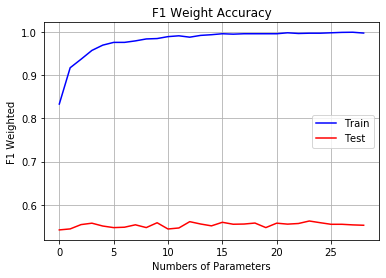

In [56]:
# Bagging KNN model
coeff, highest, train_scores, test_scores = Bagging(KNN, Train_X, Train_Y, Valid_X, Valid_Y)
plot(train_scores, test_scores)

In [57]:
Bagging_KNN = BaggingClassifier(base_estimator=KNN, n_estimators=coeff, random_state=rng)
Bagging_KNN.fit(Train_X, Train_Y)
Bagging_KNN.score(Train_X,Train_Y)

0.995575221238938

In [58]:
Bagging_KNN.score(Test_X, Test_Y)

0.62

In [59]:
print(sklearn.metrics.classification_report(Test_Y, Bagging_KNN.predict(Test_X)) )

              precision    recall  f1-score   support

           1       0.68      0.78      0.73       122
           2       0.42      0.25      0.31        65
           3       0.57      1.00      0.72        13

    accuracy                           0.62       200
   macro avg       0.56      0.67      0.59       200
weighted avg       0.59      0.62      0.59       200



0.5949565879389855


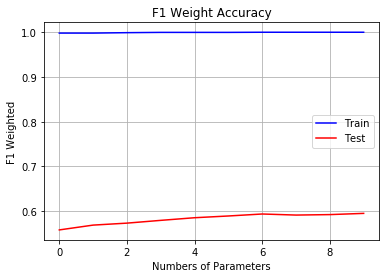

In [60]:
# Gradient Boosting Decision Tree KNN model 

coeff, highest, train_scores, test_scores = GBDT(Bagging_KNN, Train_X, Train_Y, Valid_X, Valid_Y)
plot(train_scores, test_scores)

In [61]:
GBDT_KNN = GradientBoostingClassifier(init = Bagging_KNN, learning_rate = coeff)
GBDT_KNN.fit(Train_X, Train_Y)
GBDT_KNN.score(Train_X,Train_Y)

0.9984197218710493

In [62]:
print(sklearn.metrics.classification_report(Train_Y, GBDT_KNN.predict(Train_X)) )

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1853
           2       1.00      1.00      1.00      1035
           3       1.00      1.00      1.00       276

    accuracy                           1.00      3164
   macro avg       1.00      1.00      1.00      3164
weighted avg       1.00      1.00      1.00      3164



In [63]:
GBDT_KNN.score(Test_X,Test_Y)

0.675

In [64]:
print(sklearn.metrics.classification_report(Test_Y, GBDT_KNN.predict(Test_X)) )

              precision    recall  f1-score   support

           1       0.73      0.77      0.75       122
           2       0.51      0.43      0.47        65
           3       0.81      1.00      0.90        13

    accuracy                           0.68       200
   macro avg       0.68      0.73      0.70       200
weighted avg       0.66      0.68      0.67       200



### SVC Classifier

In [65]:
svc = SVC(gamma='scale', kernel = "rbf", degree = 225, C = 10, probability = True)


svc.fit(Train_X, Train_Y)
svc.score(Train_X,Train_Y)

0.8678887484197219

In [66]:
print(sklearn.metrics.classification_report(Train_Y, svc.predict(Train_X)) )

              precision    recall  f1-score   support

           1       0.84      0.95      0.89      1853
           2       0.90      0.68      0.77      1035
           3       0.98      0.99      0.99       276

    accuracy                           0.87      3164
   macro avg       0.91      0.87      0.88      3164
weighted avg       0.87      0.87      0.86      3164



In [68]:
svc.score(Test_X,Test_Y)

0.655

In [69]:
print(sklearn.metrics.classification_report(Test_Y, svc.predict(Test_X)) )

              precision    recall  f1-score   support

           1       0.68      0.81      0.74       122
           2       0.47      0.31      0.37        65
           3       1.00      0.92      0.96        13

    accuracy                           0.66       200
   macro avg       0.72      0.68      0.69       200
weighted avg       0.63      0.66      0.64       200



0.5663932494551673


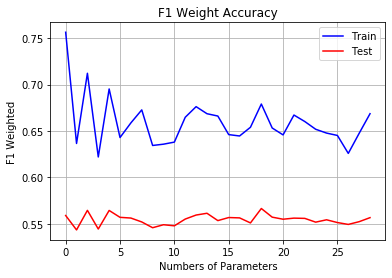

In [70]:
# Bagging Support Vector Classifier model
coeff, highest, train_scores, test_scores = Bagging(svc, Train_X, Train_Y, Valid_X, Valid_Y)
plot(train_scores, test_scores)

In [71]:
Bagging_SVC = BaggingClassifier(base_estimator=svc, n_estimators=coeff, random_state=rng)
Bagging_SVC.fit(Train_X, Train_Y)
Bagging_SVC.score(Train_X,Train_Y)

0.7484197218710493

In [72]:
print(sklearn.metrics.classification_report(Train_Y, Bagging_SVC.predict(Train_X)) )

              precision    recall  f1-score   support

           1       0.70      0.99      0.82      1853
           2       0.97      0.25      0.39      1035
           3       0.98      0.99      0.98       276

    accuracy                           0.75      3164
   macro avg       0.88      0.74      0.73      3164
weighted avg       0.81      0.75      0.70      3164



In [73]:
Bagging_SVC.score(Test_X,Test_Y)

0.685

In [74]:
print(sklearn.metrics.classification_report(Test_Y, Bagging_SVC.predict(Test_X)) )

              precision    recall  f1-score   support

           1       0.67      0.97      0.79       122
           2       0.64      0.11      0.18        65
           3       1.00      0.92      0.96        13

    accuracy                           0.69       200
   macro avg       0.77      0.67      0.64       200
weighted avg       0.68      0.69      0.60       200



0.6336491350748683


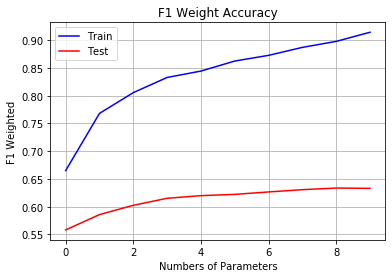

In [75]:
# Gradient Boosting Decision Tree Support Vector Classifier model 

coeff, highest, train_scores, test_scores = GBDT(Bagging_SVC, Train_X, Train_Y, Valid_X, Valid_Y)
plot(train_scores, test_scores)

In [76]:
GBDT_SVC = GradientBoostingClassifier(init = Bagging_SVC, learning_rate = coeff)
GBDT_SVC.fit(Train_X, Train_Y)
GBDT_SVC.score(Train_X,Train_Y)

0.859039190897598

In [77]:
print(sklearn.metrics.classification_report(Train_Y, GBDT_SVC.predict(Train_X)) )

              precision    recall  f1-score   support

           1       0.82      0.98      0.89      1853
           2       0.94      0.61      0.74      1035
           3       1.00      1.00      1.00       276

    accuracy                           0.86      3164
   macro avg       0.92      0.86      0.88      3164
weighted avg       0.87      0.86      0.85      3164



In [78]:
GBDT_SVC.score(Test_X,Test_Y)

0.715

In [79]:
print(sklearn.metrics.classification_report(Test_Y, GBDT_SVC.predict(Test_X)) )

              precision    recall  f1-score   support

           1       0.71      0.89      0.79       122
           2       0.62      0.32      0.42        65
           3       1.00      1.00      1.00        13

    accuracy                           0.71       200
   macro avg       0.78      0.74      0.74       200
weighted avg       0.70      0.71      0.69       200



### Random Forest

In [80]:
RF = RandomForestClassifier(random_state=0)
RF.fit(Train_X, Train_Y)
RF.score(Train_X, Train_Y)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9835651074589128

In [81]:
print(sklearn.metrics.classification_report(Train_Y, RF.predict(Train_X)) )

              precision    recall  f1-score   support

           1       0.98      1.00      0.99      1853
           2       0.99      0.96      0.98      1035
           3       1.00      0.98      0.99       276

    accuracy                           0.98      3164
   macro avg       0.99      0.98      0.98      3164
weighted avg       0.98      0.98      0.98      3164



In [82]:
RF.score(Test_X, Test_Y)

0.68

In [83]:
print(sklearn.metrics.classification_report(Test_Y, RF.predict(Test_X)) )

              precision    recall  f1-score   support

           1       0.69      0.89      0.78       122
           2       0.58      0.34      0.43        65
           3       1.00      0.38      0.56        13

    accuracy                           0.68       200
   macro avg       0.76      0.54      0.59       200
weighted avg       0.68      0.68      0.65       200



0.5799063179703633


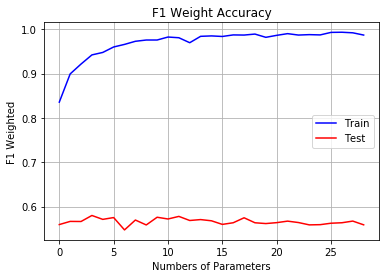

In [84]:
# Bagging Random Forest 
coeff, highest, train_scores, test_scores = Bagging(RF, Train_X, Train_Y, Valid_X, Valid_Y)
plot(train_scores, test_scores)

In [85]:
Bagging_RF = BaggingClassifier(base_estimator=RF, n_estimators=coeff, random_state=rng)
Bagging_RF.fit(Train_X, Train_Y)
Bagging_RF.score(Train_X,Train_Y)

0.9472187104930467

In [86]:
print(sklearn.metrics.classification_report(Train_Y, Bagging_RF.predict(Train_X)) )

              precision    recall  f1-score   support

           1       0.92      1.00      0.96      1853
           2       0.99      0.86      0.92      1035
           3       1.00      0.96      0.98       276

    accuracy                           0.95      3164
   macro avg       0.97      0.94      0.95      3164
weighted avg       0.95      0.95      0.95      3164



In [87]:
Bagging_RF.score(Train_X,Train_Y)

0.9472187104930467

In [88]:
print(sklearn.metrics.classification_report(Test_Y, Bagging_RF.predict(Test_X)) )

              precision    recall  f1-score   support

           1       0.66      0.89      0.76       122
           2       0.53      0.25      0.34        65
           3       1.00      0.54      0.70        13

    accuracy                           0.66       200
   macro avg       0.73      0.56      0.60       200
weighted avg       0.64      0.66      0.62       200



0.6156857786471426


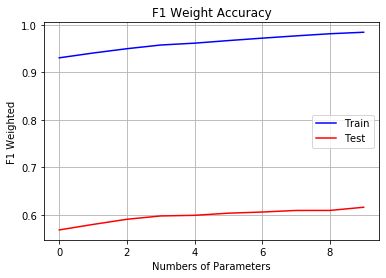

In [89]:
# Gradient Boosting Decision Tree Random Forest model 

coeff, highest, train_scores, test_scores = GBDT(Bagging_RF, Train_X, Train_Y, Valid_X, Valid_Y)
plot(train_scores, test_scores)

In [90]:
GBDT_RF = GradientBoostingClassifier(init = Bagging_RF, learning_rate = coeff)
GBDT_RF.fit(Train_X, Train_Y)
GBDT_RF.score(Train_X,Train_Y)

0.968078381795196

In [91]:
print(sklearn.metrics.classification_report(Train_Y, GBDT_RF.predict(Train_X)) )

              precision    recall  f1-score   support

           1       0.95      0.99      0.97      1853
           2       0.99      0.92      0.95      1035
           3       1.00      0.99      1.00       276

    accuracy                           0.97      3164
   macro avg       0.98      0.97      0.97      3164
weighted avg       0.97      0.97      0.97      3164



In [92]:
GBDT_RF.score(Test_X,Test_Y)

0.655

In [93]:
print(sklearn.metrics.classification_report(Test_Y, GBDT_RF.predict(Test_X)) )

              precision    recall  f1-score   support

           1       0.67      0.86      0.76       122
           2       0.47      0.25      0.32        65
           3       1.00      0.77      0.87        13

    accuracy                           0.66       200
   macro avg       0.71      0.63      0.65       200
weighted avg       0.63      0.66      0.62       200



### Ensembling Learning

### Voting 

In [94]:
model_list = [GBDT_RF, GBDT_SVC, GBDT_NB, KNN]
model_list_labels = ["GBDT_RF", "GBDT_SVC", "GBDT_NB", "KNN"]


lists = []
for i in zip(model_list_labels,model_list):
    lists.append(i)

In [95]:
VC_models = VotingClassifier(estimators=lists)
VC_models.fit(Train_X, Train_Y)
VC_models.score(Train_X, Train_Y)

0.877370417193426

In [96]:
print(sklearn.metrics.classification_report(Train_Y, VC_models.predict(Train_X)) )

              precision    recall  f1-score   support

           1       0.83      1.00      0.91      1853
           2       0.99      0.63      0.77      1035
           3       1.00      0.99      0.99       276

    accuracy                           0.88      3164
   macro avg       0.94      0.87      0.89      3164
weighted avg       0.90      0.88      0.87      3164



In [97]:
VC_models.score(Test_X, Test_Y)

0.71

In [98]:
print(sklearn.metrics.classification_report(Test_Y, VC_models.predict(Test_X)) )

              precision    recall  f1-score   support

           1       0.69      0.94      0.80       122
           2       0.68      0.23      0.34        65
           3       1.00      0.92      0.96        13

    accuracy                           0.71       200
   macro avg       0.79      0.70      0.70       200
weighted avg       0.71      0.71      0.66       200



### Stacking 

In [99]:
Stacking_X = np.append(Train_X, Valid_X,  axis=0)
Stacking_Y = np.append(Train_Y, Valid_Y)

In [100]:
meta = MLPClassifier(alpha = 20, solver = "adam", activation = "relu", max_iter = 1000) # early stop
model_list = [GBDT_RF, GBDT_SVC, GBDT_NB, KNN]


SC_models = StackingClassifier(classifiers=model_list, meta_classifier=meta)
SC_models.fit(Stacking_X, Stacking_Y)
SC_models.score(Stacking_X, Stacking_Y)

0.9589460784313726

In [101]:
print(sklearn.metrics.classification_report(Stacking_Y, SC_models.predict(Stacking_X)))

              precision    recall  f1-score   support

           1       0.97      1.00      0.98      1901
           2       0.94      0.94      0.94      1076
           3       1.00      0.78      0.87       287

    accuracy                           0.96      3264
   macro avg       0.97      0.90      0.93      3264
weighted avg       0.96      0.96      0.96      3264



In [102]:
SC_models.score(Test_X, Test_Y)

0.67

In [103]:
print(sklearn.metrics.classification_report(Test_Y, SC_models.predict(Test_X)) )

              precision    recall  f1-score   support

           1       0.71      0.87      0.78       122
           2       0.49      0.32      0.39        65
           3       1.00      0.54      0.70        13

    accuracy                           0.67       200
   macro avg       0.73      0.58      0.62       200
weighted avg       0.65      0.67      0.65       200



### Visualisation 

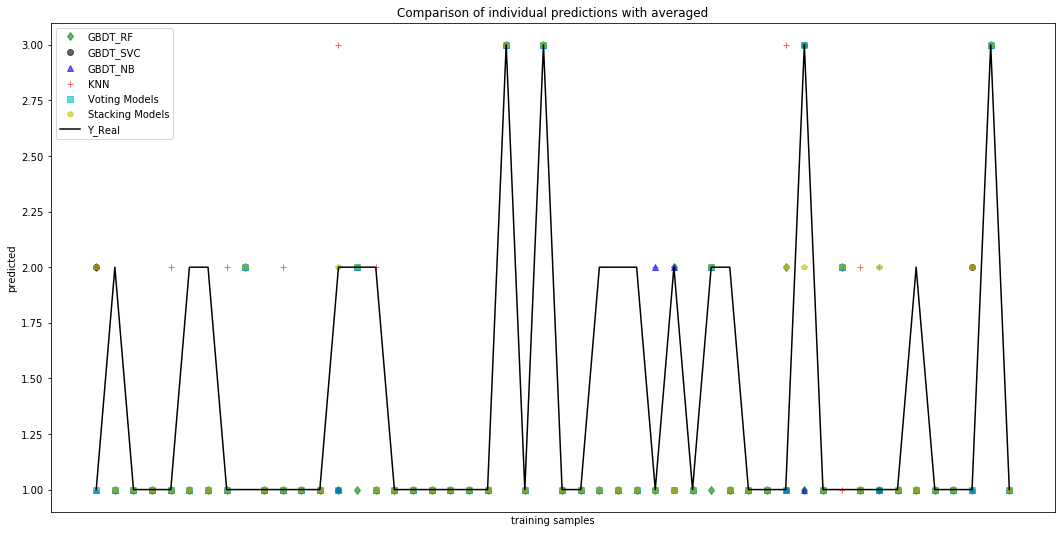

In [104]:
# model_list = [GBDT_RF, Bagging_SVC, GBDT_NB, KNN]
# model_list_labels = ["GBDT_RF", "Bagging_SVC", "GBDT_NB", "KNN"]


num = 50
xt = Test_X[:num]

alpha = 0.6
plt.figure(figsize=(18,9))
plt.plot(GBDT_RF.predict(xt), 'gd',alpha = alpha, label='GBDT_RF')
plt.plot(GBDT_SVC.predict(xt), 'ko',alpha = alpha, label='GBDT_SVC')
plt.plot(GBDT_NB.predict(xt), 'b^',alpha = alpha, label='GBDT_NB')
plt.plot(KNN.predict(xt), 'r+',alpha = alpha, label='KNN')
plt.plot(VC_models.predict(xt), 'cs',alpha = alpha, label='Voting Models')
plt.plot(SC_models.predict(xt), 'yp',alpha = alpha, label='Stacking Models')
plt.plot(Test_Y[:num], 'black', label='Y_Real')


plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Comparison of individual predictions with averaged')
plt.savefig('result.pdf')
plt.show()


